<a href="https://colab.research.google.com/github/myers1091/UmpqQuant_GroupLearningSeminar/blob/main/hnorem/session07/Ch15_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape

(7000, 50, 1)

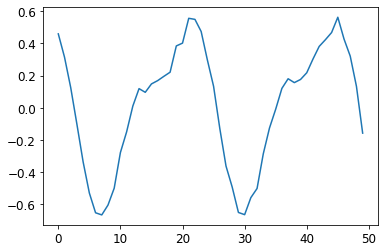

In [ ]:
plt.plot(X_train[0])

In [ ]:
y_train[0]

array([-0.35489398], dtype=float32)

In [ ]:
X_train[0][-1]

array([-0.15862931], dtype=float32)

In [ ]:
#series[0]
# ok makes sense

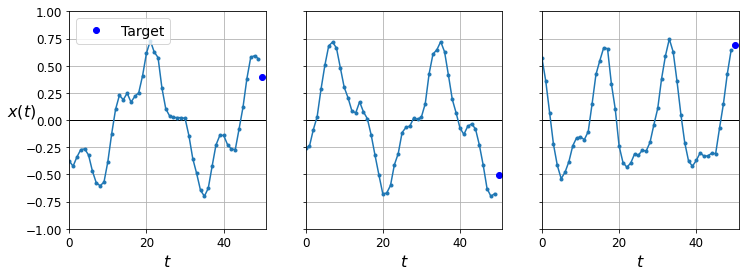

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
    
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 30s 119ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
 46/219 [=====>........................] - ETA: 19s - loss: 0.0058

KeyboardInterrupt: ignored

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 19s 78ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
211/219 [===========================>..] - ETA: 0s - loss: 0.0035

KeyboardInterrupt: ignored

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 21ms/step


In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X_train.shape

(7000, 50, 1)

In [ ]:
Y_train.shape

(7000, 10)

In [ ]:
series[0].shape

(60, 1)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000] 
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
Y_train[0].shape

(50, 10)

In [ ]:
X_train.shape

(7000, 50, 1)

In [ ]:
Y_train.shape

(7000, 50, 10)

In [ ]:
Y_train[0][0]

array([ 0.33874455,  0.18980233,  0.00611999, -0.19590542, -0.38614848,
       -0.54409838, -0.62904716, -0.66339582, -0.65724516, -0.51447874])

In [ ]:
X_train[0]

array([[ 0.4596948 ],
       [ 0.33874455],
       [ 0.18980233],
       [ 0.00611999],
       [-0.19590542],
       [-0.38614848],
       [-0.5440984 ],
       [-0.62904716],
       [-0.6633958 ],
       [-0.65724516],
       [-0.51447874],
       [-0.42731112],
       [-0.2628813 ],
       [-0.11098029],
       [-0.06872579],
       [ 0.04623062],
       [ 0.10372286],
       [ 0.1274432 ],
       [ 0.11077672],
       [ 0.20935486],
       [ 0.1686173 ],
       [ 0.30519226],
       [ 0.34892887],
       [ 0.40506098],
       [ 0.43279782],
       [ 0.5162226 ],
       [ 0.49817306],
       [ 0.45241815],
       [ 0.4086634 ],
       [ 0.21097626],
       [ 0.02851706],
       [-0.13651516],
       [-0.40563533],
       [-0.5133381 ],
       [-0.6187918 ],
       [-0.6725328 ],
       [-0.60458714],
       [-0.50924724],
       [-0.4335859 ],
       [-0.29299685],
       [-0.14998436],
       [-0.00957834],
       [ 0.0731602 ],
       [ 0.08528376],
       [ 0.10068075],
       [ 0

In [ ]:

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 23s 89ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

# Exercise 9

Train a classification model for the SketchRNN dataset.

https://github.com/googlecreativelab/quickdraw-dataset

Reading the documentation, this is a timeseries of the brushstrokes by the last row made up of timestamps.

Looking at examples, I do not see a timestamp, so I assume we just take index as time.

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 [==============================] - 34s 0us/step


In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [5]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

In [18]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return flat_sketches, sketches, lengths, labels

In [19]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [20]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

See the difference! It's just a color channel split.

In [25]:
[(A.numpy().shape, B.numpy().shape, C.numpy(), D.numpy()) for A, B, C, D in train_set.take(1)]

[((32, 306),
  (32, 102, 3),
  array([ 37,  67,  63,  29,  56,  44,  39,  46,  31,  47,  36,  41,  80,
          22,  30,  35,  21,  35,  34,  40,  17,  37, 102,  33,  19,  39,
          27,  39,  22,  19,  19,  61]),
  array([241, 218, 181, 309, 322, 188,  77, 251,  85, 217,  65, 194, 290,
         244,  78,  39, 178, 326, 278, 343, 256, 111, 176, 171, 122, 137,
         275, 231, 255, 138,   0,  25]))]

In [26]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [27]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [28]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

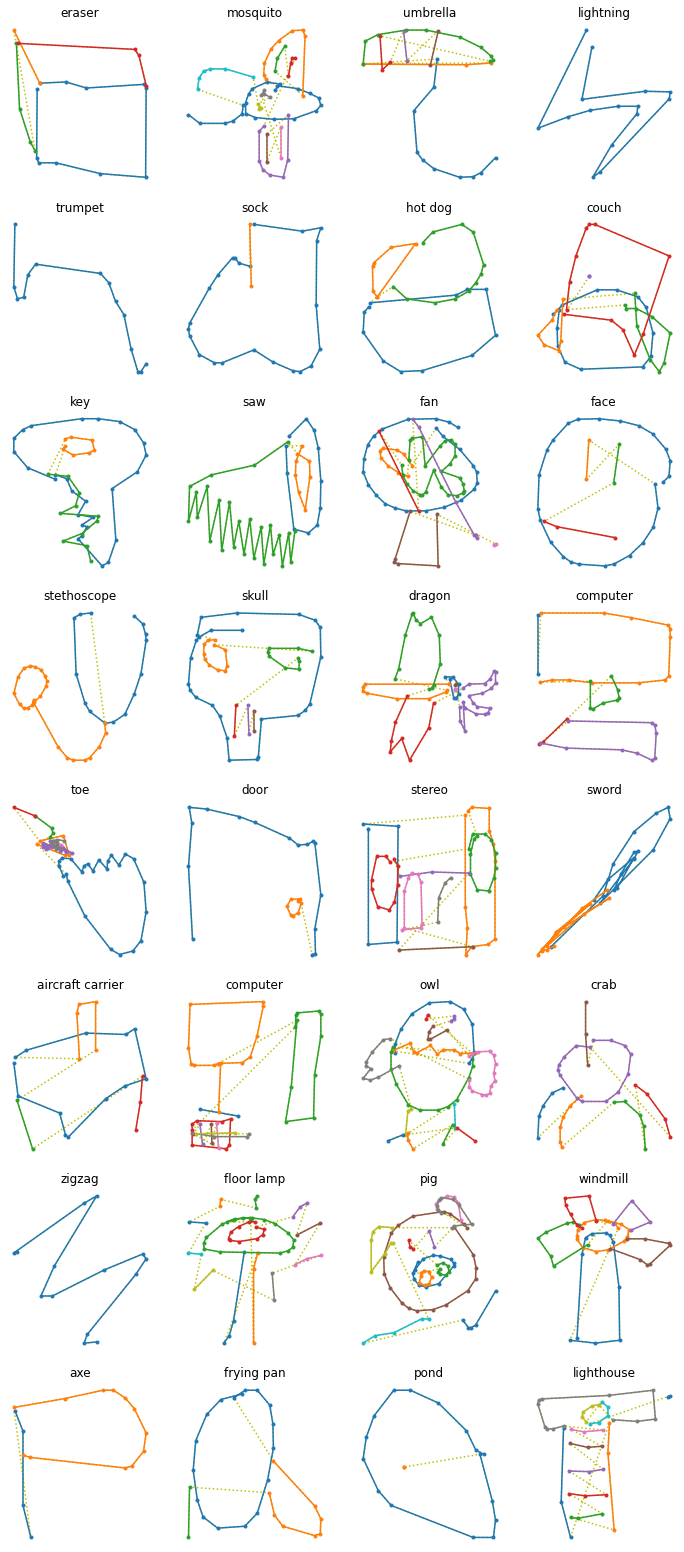

In [29]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

This code example helps me see how to get at metadata in a usable way!

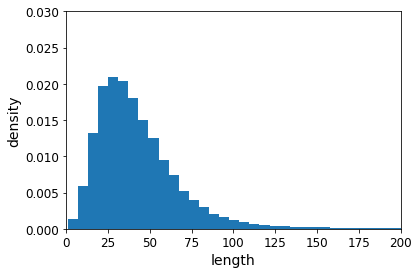

In [30]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [31]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [33]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),# strides of 2, shrinking image by half pixels each time
    keras.layers.BatchNormalization(), # then making up for shrinking pixels with larger number of channels
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(32, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(), 
    keras.layers.LSTM(32, return_sequences=True), # double LSTM layer, I guess bc ppl draw the key lines first?
    keras.layers.LSTM(32),# have to wonder how much you lose by just viewing it as a flat image...
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1199s 11ms/step - loss: 4.8990 - accuracy: 0.0664 - sparse_top_k_categorical_accuracy: 0.1917 - val_loss: 4.0301 - val_accuracy: 0.1611 - val_sparse_top_k_categorical_accuracy: 0.3925
Epoch 2/2
107813/107813 [==============================] - 1196s 11ms/step - loss: 3.6347 - accuracy: 0.2183 - sparse_top_k_categorical_accuracy: 0.4793 - val_loss: 3.3203 - val_accuracy: 0.2663 - val_sparse_top_k_categorical_accuracy: 0.5452


In [34]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 26s 5ms/step


In [35]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.41896966

1/1 [==============================] - 1s 837ms/step


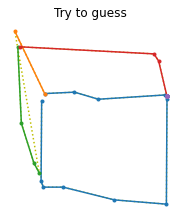

Top-5 predictions:
  1. television 14.652%
  2. cooler 7.002%
  3. house 6.853%
  4. dresser 4.398%
  5. barn 4.247%
Answer: eraser


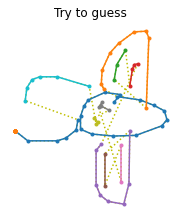

Top-5 predictions:
  1. rabbit 8.970%
  2. lobster 4.722%
  3. scorpion 4.583%
  4. mosquito 4.039%
  5. crab 3.738%
Answer: mosquito


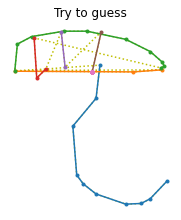

Top-5 predictions:
  1. birthday cake 14.902%
  2. cake 11.041%
  3. hot tub 6.750%
  4. bathtub 5.585%
  5. microphone 4.243%
Answer: umbrella


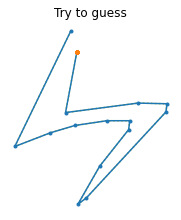

Top-5 predictions:
  1. lightning 27.818%
  2. zigzag 14.838%
  3. star 6.605%
  4. golf club 6.015%
  5. leg 3.331%
Answer: lightning


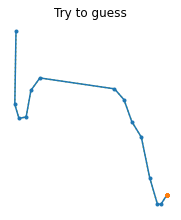

Top-5 predictions:
  1. stairs 16.960%
  2. knee 6.693%
  3. river 5.873%
  4. nose 5.833%
  5. line 4.523%
Answer: trumpet


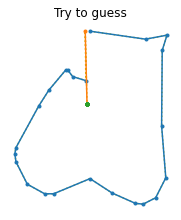

Top-5 predictions:
  1. sock 12.295%
  2. shoe 11.639%
  3. watermelon 6.004%
  4. potato 3.770%
  5. fish 3.701%
Answer: sock


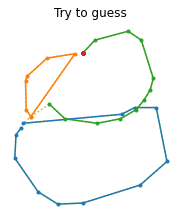

Top-5 predictions:
  1. purse 12.660%
  2. bucket 8.746%
  3. suitcase 7.643%
  4. sailboat 5.512%
  5. cruise ship 5.493%
Answer: hot dog


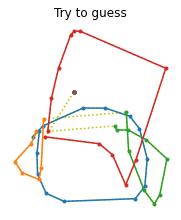

Top-5 predictions:
  1. couch 29.532%
  2. barn 3.981%
  3. belt 2.946%
  4. toilet 2.669%
  5. lantern 2.471%
Answer: couch


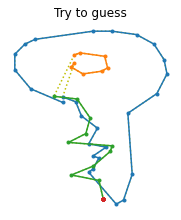

Top-5 predictions:
  1. butterfly 13.062%
  2. fire hydrant 4.842%
  3. snail 3.242%
  4. brain 2.704%
  5. backpack 2.662%
Answer: key


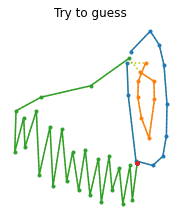

Top-5 predictions:
  1. saw 34.138%
  2. bat 8.697%
  3. crocodile 4.820%
  4. horse 3.521%
  5. dragon 1.808%
Answer: saw


In [36]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))